In [121]:
import gym
import numpy as np
from IPython import display
import time

import pandas as pd
import seaborn as sn
from matplotlib import pyplot as plt

%matplotlib inline

## The environment

[Frozen Lake 8x8 environmnet](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py)

In [122]:
# Have a look at the frozen lake environment
env = gym.make('FrozenLake-v0')
# env = gym.make('FrozenLake8x8-v0')
# Action dict from source
action_dict = {'LEFT': 0, 'DOWN': 1, 'RIGHT': 2, 'UP': 3}
done = False
env.reset()
obs_list = []
while not done:
    display.clear_output(wait=True)
    time.sleep(0.5)
    env.render()
    obs, reward, done, info= env.step(env.action_space.sample()) # take a random action
    obs_list.append((obs, reward, done, info))
env.close()

  (Down)
SFFF
FHFH
FFFH
HFFG


In [123]:
env.__dict__

{'env': <gym.envs.toy_text.frozen_lake.FrozenLakeEnv at 0x24ed718c788>,
 'action_space': Discrete(4),
 'observation_space': Discrete(16),
 'reward_range': (0, 1),
 'metadata': {'render.modes': ['human', 'ansi']},
 '_max_episode_steps': 100,
 '_elapsed_steps': 4}

In [124]:
# Random Start Monte Carlo Q learning 
# env = gym.make('FrozenLake-v0', is_slippery=False)
env = gym.make('FrozenLake8x8-v0', is_slippery=False)
env_map = env.env.desc
term_state_flag = np.array([[s for s in row] for row in env_map])
map_shape = term_state_flag.shape
term_state_flag = np.isin(term_state_flag, [b'H', b'G']).reshape(-1) #T.reshape(-1)
print(env_map)

[[b'S' b'F' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'F' b'F' b'H' b'F' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'F' b'F' b'F']
 [b'F' b'H' b'H' b'F' b'F' b'F' b'H' b'F']
 [b'F' b'H' b'F' b'F' b'H' b'F' b'H' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'F' b'F' b'G']]


In [125]:
possible_starts = np.array(range(len(term_state_flag)))[np.logical_not(term_state_flag)]
absorbing_states = np.array(range(len(term_state_flag)))[term_state_flag]

In [134]:
# MODEL INPUTS

# State action space dims
n_actions = env.action_space.n
n_states = env.observation_space.n
qshape = (n_states, n_actions)
actions=list(range(n_actions))

# Tamper reward?
change_reward = False
r_goal = 10
r_fail = -10
r_standard = -0.1
# Exploring Strarts? 
random_starts = False

# algorithm parameters
num_episodes = 5000
max_steps = 100
gamma = 0.9
epsilon = 0.3

In [135]:
# Initialise the policy (random policy)
p = np.random.randint(low=0, high=n_actions-1, size=n_states)
Q = np.zeros(qshape)
counter = np.zeros(Q.shape)
Returns = np.zeros(Q.shape)

# storing lists
exploring_starts = []
total_episode_reward = []

for episode in range(num_episodes):
    
    if episode%100 == 0: 
        print(">> episode %d" % episode)
    
    env.reset()
    done = False
    G = 0
    # steps counter
    steps = 0
    # log states, actions and reward as tuples for each trace
    trace = []
    rewards = []
    # pick a random state as the starting state
    # starting state shouldn't be a terminal (or absorbing)
    if random_starts:
        obs = possible_starts[np.random.randint(len(possible_starts))]
        exploring_starts.append(obs)
        env.env.s = obs
    else:
        obs = env.env.s
        if obs != 0:
            print('SHADY STUFF')

    # get trace
    # stop when a terminal state is reached or when the max steps per trace are reached
    while (not done) & (steps < max_steps):
        
        # picking actions (epsilon-Greedy)
        action = p[obs]
        p_probs = np.ones(n_actions)*epsilon/(n_actions)
        p_probs[action] += 1 - epsilon
        action = np.random.choice(actions, p=p_probs)
        
        steps += 1
        
        # interact with the environment
        new_obs, reward, done, _= env.step(int(action))
        
        # change the reward to speed up learning
        if change_reward:
            if reward == 1:
                reward = r_goal
            elif reward==0 and done:
                reward = r_fail
            else:
                reward = r_move
        
        # Store state, action and reward
        trace.append((obs, action))
        rewards.append(reward)
        
        # move state
        obs = new_obs
    
    # at the end of trace
    total_episode_reward.append(sum(rewards))
    
    # trace = list(reversed(trace))
    # rewards = list(reversed(rewards))
    
    # First visit algorithm needs the if statement below
    for step in reversed(range(len(trace))):
        if trace[step] not in trace[:step]:
            
            
            """
            # Debug
            if sum(rewards[step:]) == 1:
                print(">> %d" % episode)
                print(" - step %d" % step)
                print(trace)
                print(trace[step])
                #print(rewards)
                #print(new_obs)
                #print('state %d, action %d rewards sum is: %.2f'
                #      % (trace[step][0], trace[step][1], sum(rewards[step:])))
                #print(obs)
                #print([gamma**i for i in range(len(rewards[step:]))])
                print(sum([rewards[step:][i]*(gamma**i)
                                         for i in range(len(rewards[step:]))]))
            """

            Returns[trace[step]] += sum([rewards[step:][i]*(gamma**i)
                                         for i in range(len(rewards[step:]))])
            counter[trace[step]] += 1
            Q[trace[step]] = Returns[trace[step]] / counter[trace[step]]
    
    # update policy
    # p = np.argmax(Q, axis=1)
    # need to put a tie breaker that chooses randomly
    p = []
    q_max = np.max(Q, axis=1).reshape(Q.shape[0], 1)
    for s in range(Q.shape[0]):
        p.append(np.random.choice(np.argwhere(Q[s] == q_max[s]).flatten()))
    p = np.array(p)

>> episode 0
>> episode 100
>> episode 200
>> episode 300
>> episode 400
>> episode 500
>> episode 600
>> episode 700
>> episode 800
>> episode 900
>> episode 1000
>> episode 1100
>> episode 1200
>> episode 1300
>> episode 1400
>> episode 1500
>> episode 1600
>> episode 1700
>> episode 1800
>> episode 1900
>> episode 2000
>> episode 2100
>> episode 2200
>> episode 2300
>> episode 2400
>> episode 2500
>> episode 2600
>> episode 2700
>> episode 2800
>> episode 2900
>> episode 3000
>> episode 3100
>> episode 3200
>> episode 3300
>> episode 3400
>> episode 3500
>> episode 3600
>> episode 3700
>> episode 3800
>> episode 3900
>> episode 4000
>> episode 4100
>> episode 4200
>> episode 4300
>> episode 4400
>> episode 4500
>> episode 4600
>> episode 4700
>> episode 4800
>> episode 4900


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.      , 0.015625, 0.03125 , 0.046875, 0.0625  , 0.078125,
        0.09375 , 0.109375, 0.125   , 0.140625, 0.15625 , 0.171875,
        0.1875  , 0.203125, 0.21875 , 0.234375, 0.25    , 0.265625,
        0.28125 , 0.296875, 0.3125  , 0.328125, 0.34375 , 0.359375,
        0.375   , 0.390625, 0.40625 , 0.421875, 0.4375  , 0.453125,
        0.46875 , 0.484375, 0.5     , 0.515625, 0.53125 , 0.546875,
        0.5625  , 0.578125, 0.59375 , 0.609375, 0.625   , 0.640625,
        0.65625 , 0.671875, 0.6875  , 0.703125, 0.71875 , 0.734375,
        0.75    , 0.765625, 0.78125 , 0.796875, 0.8125  , 0.828125,
        0.84375 , 0.859375, 0.875   , 0.890625, 0.90625 , 0.921875,
        0.9375  , 0.953125, 0.

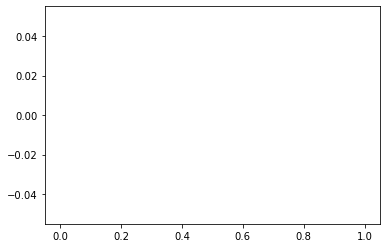

In [136]:
plt.hist(exploring_starts, bins=n_states)

(0.0, 1.0)

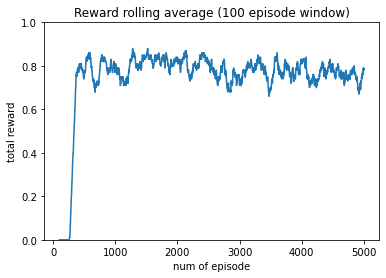

In [137]:
reward_rolling_average = pd.DataFrame()
N = 100
reward_rolling_average['episode reward'] = total_episode_reward
reward_rolling_average['episode reward rolling average (%d)'%N] = (reward_rolling_average.
                                                                   rolling(window=N).
                                                                   mean())

plt.plot(reward_rolling_average['episode reward rolling average (%d)'%N])
plt.title("Reward rolling average (%d episode window)" % N)
plt.xlabel("num of episode")
plt.ylabel("total reward")
plt.ylim((0, 1))

In [138]:
#print(Q)
print('V is:')
print(np.around(np.max(Q, axis=1).reshape(map_shape), decimals=2))
print("")
print("recommeded actions are:")
print(action_dict)
print(p.reshape(map_shape))

V is:
[[0.11 0.13 0.16 0.18 0.21 0.24 0.29 0.24]
 [0.08 0.11 0.13 0.18 0.24 0.29 0.34 0.4 ]
 [0.04 0.08 0.06 0.   0.22 0.33 0.39 0.46]
 [0.   0.01 0.03 0.03 0.13 0.   0.44 0.54]
 [0.   0.   0.02 0.   0.1  0.41 0.55 0.64]
 [0.   0.   0.   0.   0.43 0.12 0.   0.8 ]
 [0.   0.   0.   0.   0.   0.27 0.   1.  ]
 [0.   0.   0.   0.   0.   0.9  1.   0.  ]]

recommeded actions are:
{'LEFT': 0, 'DOWN': 1, 'RIGHT': 2, 'UP': 3}
[[2 2 2 2 2 1 1 0]
 [2 3 2 2 2 2 1 1]
 [2 3 3 0 2 2 2 1]
 [1 3 3 0 3 2 2 1]
 [2 0 3 3 1 2 2 1]
 [3 3 2 3 2 1 0 1]
 [3 0 3 3 0 1 0 1]
 [1 3 2 3 3 2 2 1]]


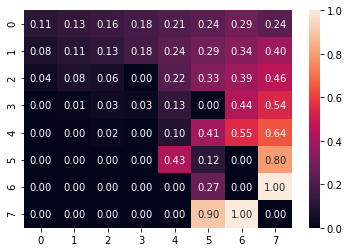

In [139]:
sn.heatmap(np.max(Q, axis=1).reshape(map_shape), annot=True, fmt="0.2f")

In [140]:
print(env.env.desc)

[[b'S' b'F' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'F' b'F' b'H' b'F' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'F' b'F' b'F']
 [b'F' b'H' b'H' b'F' b'F' b'F' b'H' b'F']
 [b'F' b'H' b'F' b'F' b'H' b'F' b'H' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'F' b'F' b'G']]


In [141]:
print('')
print(term_state_flag.reshape(map_shape))

0
[[False False False False False False False False]
 [False False False False False False False False]
 [False False False  True False False False False]
 [False False False False False  True False False]
 [False False False  True False False False False]
 [False  True  True False False False  True False]
 [False  True False False  True False  True False]
 [False False False  True False False False  True]]


### Testing

In [ ]:
p = np.random.randint(low=0, high=n_actions, size=n_states)

In [62]:
# Creating the tie breaker

# Dummy matrix with one clear max
M = np.ones((3,4))
M[0][0] = 2
M[1][2] = 3
M[1][1] = 3
M[2][2] = 4

# change dims to make sure it broadcasts
p = []
m = np.max(M, axis=1).reshape(M.shape[0], 1)
for row in range(M.shape[0]):
    p.append(np.random.choice(np.argwhere(M[row]==m[row]).flatten()))
print(M)
print(p)
# Need argmax


[[2. 1. 1. 1.]
 [1. 3. 3. 1.]
 [1. 1. 4. 1.]]
[0, 2, 2]


In [56]:
print(p)

[]


In [4]:
# Define an abstract class for all Tabular RL algorithms
class TabularRL(object):
    """
    Abstract class definition
    """
    def __init__(self):
        super().__init__()

    def learn(self):
        raise NotImplementedError('This is an abstract method.')

In [ ]:
type(int(p[0]))

In [ ]:
custom_map = [
    'SFFFF',
    'HHHHF',
    'HHHHF',
    'HHHHF',
    'HHHHG'
]

custom_map = [
    'SFFFF',
    'FFFFF',
    'FHFFF',
    'FFFFF',
    'FFFFG'
]